# 预测结果json文件__去除__重复的预测__获取__唯一预测结果json文件
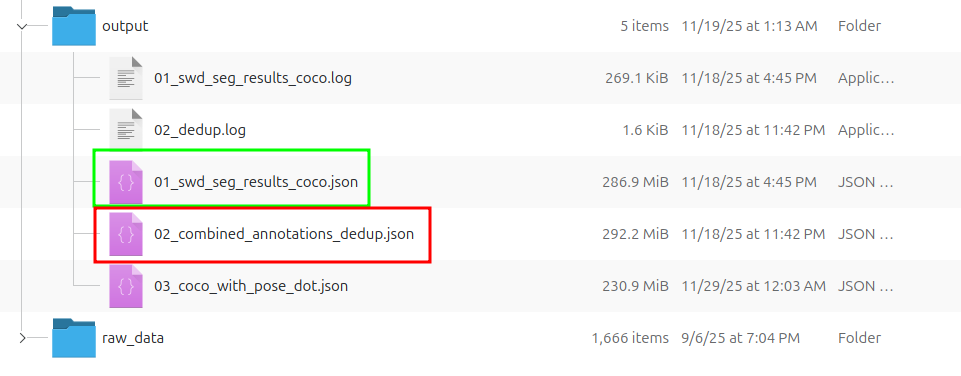

In [ ]:
from __future__ import annotations

import argparse
import json
import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Iterable, List, Literal, Optional, Tuple
from datetime import datetime
from zoneinfo import ZoneInfo

# === 强制使用美国中部时间 CST/CDT ===
CENTRAL_TZ = ZoneInfo("US/Central")


def central_time(*args):
    return datetime.now(CENTRAL_TZ).timetuple()


# ============================================================
# 日志
# ============================================================

LOGGER: logging.Logger = logging.getLogger(__name__)

# ============================================================
# 类型别名
# ============================================================

BoundingBox = Tuple[float, float, float, float]
DedupMethod = Literal["NMS", "NMM", "GREEDYNMM", "LSNMS"]
OverlapMetric = Literal["IOU", "IOS"]
KeepStrategy = Literal["highest_score"]

# ============================================================
# 配置 dataclass
# ============================================================


@dataclass
class ProcessingConfig:
    """去重相关配置."""
    method: DedupMethod = "NMS"
    overlap_metric: OverlapMetric = "IOS"
    overlap_threshold: float = 0.5
    class_agnostic: bool = False
    keep_strategy: KeepStrategy = "highest_score"  # 目前仅支持 highest_score


@dataclass
class PipelineConfig:
    """输入输出 JSON 路径配置（支持多文件批处理）."""
    input_jsons: List[Path]
    output_jsons: List[Path]


@dataclass
class LoggingConfig:
    """日志配置."""
    level: str = "INFO"
    log_to_file: bool = True
    log_file_name: str = "dedup.log"
    overwrite_log_file: bool = True


@dataclass
class AppConfig:
    """顶层应用配置，负责从 YAML 加载."""
    processing: ProcessingConfig
    pipeline: PipelineConfig
    logging: LoggingConfig

    @staticmethod
    def _to_path(value: Any) -> Path:
        if isinstance(value, Path):
            return value
        return Path(str(value))

    @classmethod
    def load_from_yaml(cls, config_path: Path) -> "AppConfig":
        import yaml  # 延迟导入

        with config_path.open("r", encoding="utf-8") as file:
            raw: Dict[str, Any] = yaml.safe_load(file)

        processing_raw: Dict[str, Any] = raw.get("processing", {})
        pipeline_raw: Dict[str, Any] = raw.get("pipeline", {})
        logging_raw: Dict[str, Any] = raw.get("logging", {})

        processing_config = ProcessingConfig(
            method=processing_raw.get("method", "NMS"),
            overlap_metric=processing_raw.get("overlap_metric", "IOS"),
            overlap_threshold=float(processing_raw.get("overlap_threshold", 0.5)),
            class_agnostic=bool(processing_raw.get("class_agnostic", False)),
            keep_strategy=processing_raw.get("keep_strategy", "highest_score"),
        )

        def _ensure_path_list(value: Any, key_name: str) -> List[Path]:
            if isinstance(value, list):
                return [cls._to_path(v) for v in value]
            if value is None:
                raise ValueError(f"`pipeline.{key_name}` is required in config.")
            # 单个字符串 / Path 时，包装成单元素列表
            return [cls._to_path(value)]

        root_dir_path_list = pipeline_raw.get("root_dir_path_list")

        root_dir_path_list = _ensure_path_list(root_dir_path_list, "root_dir_path_list")

        input_json_subpath = pipeline_raw.get("input_json_subpath", "")
        output_json_subpath = pipeline_raw.get("output_json_subpath", "")

        input_jsons: List[Path] = []
        output_jsons: List[Path] = []

        if input_json_subpath:
            input_jsons = [p / input_json_subpath for p in root_dir_path_list]
        if output_json_subpath:
            output_jsons = [p / output_json_subpath for p in root_dir_path_list]

        pipeline_config = PipelineConfig(
            input_jsons=input_jsons,
            output_jsons=output_jsons,
        )

        logging_config = LoggingConfig(
            level=logging_raw.get("level", "INFO"),
            log_to_file=bool(logging_raw.get("log_to_file", True)),
            log_file_name=logging_raw.get("log_file_name", "dedup.log"),
            overwrite_log_file=bool(logging_raw.get("overwrite_log_file", True)),
        )

        return cls(
            processing=processing_config,
            pipeline=pipeline_config,
            logging=logging_config,
        )


# ============================================================
# 领域对象 dataclass
# ============================================================


@dataclass
class CocoImage:
    id: int
    file_name: str
    width: int
    height: int
    license: Optional[int] = None
    date_captured: Optional[str] = None
    focal_length_parameter: Optional[float] = None


@dataclass
class CocoCategory:
    id: int
    name: str
    supercategory: Optional[str] = None


@dataclass
class CocoAnnotation:
    id: int
    image_id: int
    category_id: int
    bbox: BoundingBox
    area: float
    iscrowd: int = 0
    score: Optional[float] = None
    object_id: Optional[str] = None
    segmentation: Optional[Any] = None

    def to_dict(self) -> Dict[str, Any]:
        data: Dict[str, Any] = {
            "id": self.id,
            "image_id": self.image_id,
            "category_id": self.category_id,
            "bbox": list(self.bbox),
            "area": self.area,
            "iscrowd": self.iscrowd,
        }
        if self.segmentation is not None:
            data["segmentation"] = self.segmentation
        if self.score is not None:
            data["score"] = self.score
        if self.object_id is not None:
            data["object_id"] = self.object_id
        return data


@dataclass
class CocoDataset:
    images: List[CocoImage]
    annotations: List[CocoAnnotation]
    categories: List[CocoCategory]
    info: Optional[Dict[str, Any]] = None
    licenses: Optional[List[Dict[str, Any]]] = None


# ============================================================
# 日志配置
# ============================================================


def configure_logging_for_directory(base_dir: Path, logging_config: LoggingConfig) -> None:
    """
    配置 LOGGER，让日志输出到：
    - 控制台
    - base_dir / log_file_name

    每调用一次会清空之前的 handlers，
    所以可以在循环里为“每个目录”单独配置一次。
    """
    base_dir.mkdir(parents=True, exist_ok=True)

    level = getattr(logging, logging_config.level.upper(), logging.INFO)
    LOGGER.setLevel(level)

    formatter = logging.Formatter(
        fmt="%(asctime)s [%(levelname)s] %(name)s - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
    )

    # 清空旧的 handler（关键：保证不会重复叠加）
    if LOGGER.handlers:
        LOGGER.handlers.clear()

    # 控制台输出
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level)
    console_handler.setFormatter(formatter)
    LOGGER.addHandler(console_handler)

    log_path: Optional[Path] = None
    if logging_config.log_to_file:
        log_path = base_dir / logging_config.log_file_name
        file_mode = "w" if logging_config.overwrite_log_file else "a"
        file_handler = logging.FileHandler(log_path, mode=file_mode, encoding="utf-8")
        file_handler.setLevel(level)
        file_handler.setFormatter(formatter)
        LOGGER.addHandler(file_handler)

    # 使用美国中部时间
    logging.Formatter.converter = central_time

    LOGGER.info("Logging configured. Base directory: %s", base_dir)
    LOGGER.info("Log path: %s", log_path if log_path is not None else "N/A")


# ============================================================
# COCO JSON 读取 / 写入
# ============================================================


def load_coco_dataset(json_path: Path) -> CocoDataset:
    LOGGER.info("Loading COCO dataset from %s", json_path)
    with json_path.open("r", encoding="utf-8") as file:
        raw: Dict[str, Any] = json.load(file)

    # 保存 info 和 licenses
    info = raw.get("info")
    licenses = raw.get("licenses")

    images: List[CocoImage] = []
    for img in raw.get("images", []):
        images.append(
            CocoImage(
                id=int(img["id"]),
                file_name=str(img["file_name"]),
                width=int(img["width"]),
                height=int(img["height"]),
                license=img.get("license"),
                date_captured=img.get("date_captured"),
                focal_length_parameter=img.get("focal_length_parameter"),
            )
        )

    categories: List[CocoCategory] = []
    for cat in raw.get("categories", []):
        categories.append(
            CocoCategory(
                id=int(cat["id"]),
                name=str(cat["name"]),
                supercategory=cat.get("supercategory"),
            )
        )

    annotations: List[CocoAnnotation] = []
    for ann in raw.get("annotations", []):
        bbox_raw = ann.get("bbox", [0.0, 0.0, 0.0, 0.0])
        bbox: BoundingBox = (
            float(bbox_raw[0]),
            float(bbox_raw[1]),
            float(bbox_raw[2]),
            float(bbox_raw[3]),
        )
        area_value = float(ann.get("area", bbox[2] * bbox[3]))
        score_value = float(ann["score"]) if "score" in ann else None
        object_id_value = ann.get("object_id")

        annotations.append(
            CocoAnnotation(
                id=int(ann["id"]),
                image_id=int(ann["image_id"]),
                category_id=int(ann["category_id"]),
                bbox=bbox,
                area=area_value,
                iscrowd=int(ann.get("iscrowd", 0)),
                score=score_value,
                object_id=object_id_value,
                segmentation=ann.get("segmentation"),
            )
        )

    LOGGER.info(
        "Loaded dataset: %d images, %d annotations, %d categories",
        len(images),
        len(annotations),
        len(categories),
    )
    return CocoDataset(
        images=images,
        annotations=annotations,
        categories=categories,
        info=info,
        licenses=licenses,
    )


def save_coco_dataset(dataset: CocoDataset, output_path: Path) -> None:
    LOGGER.info("Saving deduplicated dataset to %s", output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    images_out: List[Dict[str, Any]] = []
    for img in dataset.images:
        data: Dict[str, Any] = {
            "id": img.id,
            "file_name": img.file_name,
            "width": img.width,
            "height": img.height,
        }
        # 添加可选字段
        if img.license is not None:
            data["license"] = img.license
        if img.date_captured is not None:
            data["date_captured"] = img.date_captured
        if img.focal_length_parameter is not None:
            data["focal_length_parameter"] = img.focal_length_parameter
        images_out.append(data)

    categories_out: List[Dict[str, Any]] = []
    for cat in dataset.categories:
        data: Dict[str, Any] = {
            "id": cat.id,
            "name": cat.name,
        }
        if cat.supercategory is not None:
            data["supercategory"] = cat.supercategory
        categories_out.append(data)

    annotations_out: List[Dict[str, Any]] = [ann.to_dict() for ann in dataset.annotations]

    # info.description 改为 SWD COCO format deduplicated instance segmentation
    if dataset.info is not None:
        dataset.info["description"] = "SWD COCO format deduplicated instance segmentation"

    # 构建完整的输出结构，包含 info 和 licenses
    raw_out: Dict[str, Any] = {
        "info": dataset.info if dataset.info is not None else {},
        "licenses": dataset.licenses if dataset.licenses is not None else [],
        "images": images_out,
        "annotations": annotations_out,
        "categories": categories_out,
    }

    with output_path.open("w", encoding="utf-8") as file:
        json.dump(raw_out, file, ensure_ascii=False, indent=4)

    LOGGER.info(
        "Saved dataset: %d images, %d annotations, %d categories",
        len(dataset.images),
        len(dataset.annotations),
        len(dataset.categories),
    )


# ============================================================
# 几何工具（只用 bbox，不用 segmentation）
# ============================================================


def convert_bbox_to_xyxy(bbox: BoundingBox) -> BoundingBox:
    x_min, y_min, width, height = bbox
    return x_min, y_min, x_min + width, y_min + height


def compute_intersection_area(bbox_a: BoundingBox, bbox_b: BoundingBox) -> float:
    ax1, ay1, ax2, ay2 = convert_bbox_to_xyxy(bbox_a)
    bx1, by1, bx2, by2 = convert_bbox_to_xyxy(bbox_b)

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_width = max(0.0, inter_x2 - inter_x1)
    inter_height = max(0.0, inter_y2 - inter_y1)
    return inter_width * inter_height


def compute_bbox_area(bbox: BoundingBox) -> float:
    return max(0.0, bbox[2]) * max(0.0, bbox[3])


def compute_overlap(
    bbox_a: BoundingBox,
    bbox_b: BoundingBox,
    metric: OverlapMetric,
) -> float:
    inter_area = compute_intersection_area(bbox_a, bbox_b)
    if inter_area <= 0.0:
        return 0.0

    area_a = compute_bbox_area(bbox_a)
    area_b = compute_bbox_area(bbox_b)

    if metric == "IOU":
        union_area = area_a + area_b - inter_area
        if union_area <= 0.0:
            return 0.0
        return inter_area / union_area

    # IOS: intersection over smaller box
    smaller_area = min(area_a, area_b)
    if smaller_area <= 0.0:
        return 0.0
    return inter_area / smaller_area


# ============================================================
# 去重核心逻辑
# ============================================================


def group_annotations_for_dedup(
    annotations: Iterable[CocoAnnotation],
    class_agnostic: bool,
) -> Dict[Tuple[int, Optional[int]], List[CocoAnnotation]]:
    grouped: Dict[Tuple[int, Optional[int]], List[CocoAnnotation]] = {}
    for ann in annotations:
        category_key: Optional[int] = None if class_agnostic else ann.category_id
        key = (ann.image_id, category_key)
        if key not in grouped:
            grouped[key] = []
        grouped[key].append(ann)
    return grouped


def sort_annotations_by_score_desc(annotations: List[CocoAnnotation]) -> List[CocoAnnotation]:
    return sorted(
        annotations,
        key=lambda ann: float(ann.score) if ann.score is not None else -1.0,
        reverse=True,
    )


def cluster_annotations_greedily(
    annotations: List[CocoAnnotation],
    processing_config: ProcessingConfig,
) -> List[List[CocoAnnotation]]:
    """
    通用"贪心聚类"：
    - 按 score 降序遍历（highest_score 代表）
    - 如果与已有 cluster 的代表框重叠 >= threshold，则归入该 cluster
    - 否则新建一个 cluster
    所有 method（NMS / NMM / GREEDYNMM / LSNMS）都基于这个聚类结果，再决定如何输出。
    """
    if not annotations:
        return []

    sorted_anns = sort_annotations_by_score_desc(annotations)
    clusters: List[List[CocoAnnotation]] = []

    for ann in sorted_anns:
        assigned = False
        for cluster in clusters:
            representative = cluster[0]  # 因为按 score 降序，cluster[0] 始终是 highest_score
            overlap_value = compute_overlap(
                ann.bbox,
                representative.bbox,
                metric=processing_config.overlap_metric,
            )
            if overlap_value >= processing_config.overlap_threshold:
                cluster.append(ann)
                assigned = True
                break
        if not assigned:
            clusters.append([ann])

    return clusters


def merge_cluster_to_single_annotation(cluster: List[CocoAnnotation]) -> CocoAnnotation:
    """
    NMM / GREEDYNMM 使用：
    - bbox 使用 score 加权平均的中心和宽高；
    - score 使用 cluster 中的最大 score；
    - segmentation 和 object_id 直接继承代表框（score 最大的那个）的。
    """
    if not cluster:
        raise ValueError("Cluster must contain at least one annotation.")

    representative = sort_annotations_by_score_desc(cluster)[0]

    # 计算权重：用 score，如果没有 score 就当 1.0
    weights: List[float] = [
        float(ann.score) if ann.score is not None else 1.0 for ann in cluster
    ]
    weight_sum = sum(weights)
    if weight_sum <= 0.0:
        weights = [1.0 for _ in cluster]
        weight_sum = float(len(cluster))

    # 将 bbox 转为中心点 + 宽高
    centers_x: List[float] = []
    centers_y: List[float] = []
    widths: List[float] = []
    heights: List[float] = []

    for ann in cluster:
        x, y, w, h = ann.bbox
        centers_x.append(x + w / 2.0)
        centers_y.append(y + h / 2.0)
        widths.append(w)
        heights.append(h)

    # score 加权平均
    merged_cx = sum(c * w for c, w in zip(centers_x, weights)) / weight_sum
    merged_cy = sum(c * w for c, w in zip(centers_y, weights)) / weight_sum
    merged_w = sum(w * wt for w, wt in zip(widths, weights)) / weight_sum
    merged_h = sum(h * wt for h, wt in zip(heights, weights)) / weight_sum

    merged_x = merged_cx - merged_w / 2.0
    merged_y = merged_cy - merged_h / 2.0
    merged_bbox: BoundingBox = (merged_x, merged_y, merged_w, merged_h)
    merged_area = compute_bbox_area(merged_bbox)

    # 新 annotation：沿用代表框的大部分属性，只更新 bbox / area
    return CocoAnnotation(
        id=representative.id,
        image_id=representative.image_id,
        category_id=representative.category_id,
        bbox=merged_bbox,
        area=merged_area,
        iscrowd=representative.iscrowd,
        score=representative.score,
        object_id=representative.object_id,
        segmentation=representative.segmentation,
    )


def deduplicate_group_annotations(
    annotations: List[CocoAnnotation],
    processing_config: ProcessingConfig,
) -> List[CocoAnnotation]:
    """
    针对同一组（同一 image_id，且 class_agnostic 控制是否按类别分组）的 annotations 做去重。
    """
    if not annotations:
        return []

    clusters = cluster_annotations_greedily(
        annotations=annotations,
        processing_config=processing_config,
    )

    method = processing_config.method.upper()

    if method == "NMS":
        # 标准 NMS：每个 cluster 只保留代表框（highest_score）
        return [sort_annotations_by_score_desc(cluster)[0] for cluster in clusters]

    if method == "NMM":
        # Non-Maximum Merging：合并 cluster 为单一 bbox
        return [merge_cluster_to_single_annotation(cluster) for cluster in clusters]

    if method == "GREEDYNMM":
        # 这里实现为与 NMM 等价的"贪心合并"，后续如有需要可改为更复杂策略
        return [merge_cluster_to_single_annotation(cluster) for cluster in clusters]

    if method == "LSNMS":
        # 目前实现为 NMS 的别名；后续可扩展为更复杂的 Local Soft-NMS 策略
        return [sort_annotations_by_score_desc(cluster)[0] for cluster in clusters]

    # 理论上不会走到这里（被 Literal 类型保护），但为了安全加一个 fallback
    LOGGER.warning("Unknown method '%s', fallback to NMS.", method)
    return [sort_annotations_by_score_desc(cluster)[0] for cluster in clusters]


def deduplicate_annotations(
    annotations: List[CocoAnnotation],
    processing_config: ProcessingConfig,
) -> List[CocoAnnotation]:
    LOGGER.info(
        "Deduplicating %d annotations (method=%s, metric=%s, threshold=%.3f, class_agnostic=%s, keep_strategy=%s)",
        len(annotations),
        processing_config.method,
        processing_config.overlap_metric,
        processing_config.overlap_threshold,
        processing_config.class_agnostic,
        processing_config.keep_strategy,
    )

    if processing_config.keep_strategy != "highest_score":
        LOGGER.warning(
            "Keep strategy '%s' is not supported yet. Falling back to 'highest_score'.",
            processing_config.keep_strategy,
        )

    grouped = group_annotations_for_dedup(
        annotations=annotations,
        class_agnostic=processing_config.class_agnostic,
    )

    deduplicated: List[CocoAnnotation] = []
    removed_count = 0

    for group_key, group_annotations in grouped.items():
        image_id, category_key = group_key
        kept = deduplicate_group_annotations(
            annotations=group_annotations,
            processing_config=processing_config,
        )
        deduplicated.extend(kept)
        removed_in_group = len(group_annotations) - len(kept)
        removed_count += removed_in_group

        if removed_in_group > 0:
            LOGGER.debug(
                "Image %s, category %s: %d -> %d (removed %d)",
                image_id,
                category_key,
                len(group_annotations),
                len(kept),
                removed_in_group,
            )

    LOGGER.info(
        "Deduplication done: %d -> %d annotations (removed %d)",
        len(annotations),
        len(deduplicated),
        removed_count,
    )
    return deduplicated


# ============================================================
# 管道入口
# ============================================================


def run_pipeline(config_path: Path) -> None:
    app_config = AppConfig.load_from_yaml(config_path=config_path)

    num_pairs = len(app_config.pipeline.input_jsons)

    for index, (input_json, output_json) in enumerate(
        zip(app_config.pipeline.input_jsons, app_config.pipeline.output_jsons),
        start=1,
    ):
        # === 关键修改点：每个 output_json 的父目录单独配置日志 ===
        base_dir = output_json.parent
        configure_logging_for_directory(
            base_dir=base_dir,
            logging_config=app_config.logging,
        )

        LOGGER.info("Using configuration file: %s", config_path)
        LOGGER.info("Number of input JSON files: %d", num_pairs)

        LOGGER.info("Processing pair %d:", index)
        LOGGER.info("  Input JSON: %s", input_json)
        LOGGER.info("  Output JSON: %s", output_json)

        dataset = load_coco_dataset(json_path=input_json)

        deduplicated_annotations = deduplicate_annotations(
            annotations=dataset.annotations,
            processing_config=app_config.processing,
        )

        deduplicated_dataset = CocoDataset(
            images=dataset.images,
            annotations=deduplicated_annotations,
            categories=dataset.categories,
            info=dataset.info,
            licenses=dataset.licenses,
        )

        save_coco_dataset(
            dataset=deduplicated_dataset,
            output_path=output_json,
        )

    # 最后一条整体提示可以保留，也会记录在最后一个目录的 log 里
    LOGGER.info("Pipeline finished for %d file pairs.", num_pairs)


In [ ]:
# ============================================================
# 命令行入口
# ============================================================

def parse_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="COCO detection deduplication pipeline.")
    parser.add_argument(
        "--config",
        type=Path,
        default=Path("config/02_config.yaml"),
        help="Path to YAML configuration file.",
    )
    args, unknown = parser.parse_known_args()
    return args

if __name__ == "__main__":
    args = parse_args()
    run_pipeline(config_path=args.config)

2025-11-24 19:34:50 [INFO] __main__ - Logging configured. Base directory: /workspace/_ty/01_data/00_test/00_try/output
2025-11-24 19:34:50 [INFO] __main__ - Log path: /workspace/_ty/01_data/00_test/00_try/output/02_dedup.log
2025-11-24 19:34:50 [INFO] __main__ - Using configuration file: 02_config.yaml
2025-11-24 19:34:50 [INFO] __main__ - Number of input JSON files: 1
2025-11-24 19:34:50 [INFO] __main__ - Processing pair 1:
2025-11-24 19:34:50 [INFO] __main__ -   Input JSON: /workspace/_ty/01_data/00_test/00_try/output/01_swd_seg_results_coco.json
2025-11-24 19:34:50 [INFO] __main__ -   Output JSON: /workspace/_ty/01_data/00_test/00_try/output/02_combined_annotations_dedup.json
2025-11-24 19:34:50 [INFO] __main__ - Loading COCO dataset from /workspace/_ty/01_data/00_test/00_try/output/01_swd_seg_results_coco.json
2025-11-24 19:34:50 [INFO] __main__ - Loaded dataset: 4 images, 333 annotations, 1 categories
2025-11-24 19:34:50 [INFO] __main__ - Deduplicating 333 annotations (method=NMS,